In [1]:
#Loading MNIST data set using keras
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train = x_train[np.random.randint(0,60000,12000),]

In [4]:
x_train.shape

(12000, 28, 28)

In [5]:
x_train = np.append(x_train,x_train,axis =0)

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

For flipping the images:

As 0.03x784 =23.52, in each image a rand value of 23 or 24 is selected and then randomly these number of pixels are flipped

In [7]:
#Flipping input images
x_train_noisy = np.copy(x_train)
for i in range(x_train.shape[0]):
    idx = np.random.randint(0,784,np.random.randint(23,25))
    x_train_noisy[i,idx] = 1 - x_train[i,idx]
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0],28,28,1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)

x_test_noisy = np.copy(x_test)
for i in range(x_test.shape[0]):
    idx = np.random.randint(0,784,np.random.randint(23,25))
    x_test_noisy[i,idx] = 1 - x_test[i,idx]
x_test_noisy = x_test_noisy.reshape(10000,28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt

Cosidering architechture 1 as base following variations are made keeping all the other things same:

Architecture2 : Reduced the number of filters from 32 to 16


Architecture3 : Increased the number of convolution layer by 2, one as the last layer of encoder and another as the first layer of decoder


Architecture4 : Incresed the filter size from 3x3 to 5x5


Please see summary of architecture for exact details


All the architecture are run for epochs=10 and batch_size = 128. This can also be fine tuned


## Architecture 1

In [9]:
#Architechture 1

input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ['mse'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [10]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 24000 samples, validate on 10000 samples
Epoch 1/10
24000/24000 [==============================] - 176s - loss: 0.2149 - mean_squared_error: 0.0496 - val_loss: 0.1233 - val_mean_squared_error: 0.0204
Epoch 2/10
24000/24000 [==============================] - 133s - loss: 0.1105 - mean_squared_error: 0.0160 - val_loss: 0.0988 - val_mean_squared_error: 0.0122
Epoch 3/10
24000/24000 [==============================] - 96s - loss: 0.0975 - mean_squared_error: 0.0116 - val_loss: 0.0926 - val_mean_squared_error: 0.0104
Epoch 4/10
24000/24000 [==============================] - 101s - loss: 0.0920 - mean_squared_error: 0.0099 - val_loss: 0.0890 - val_mean_squared_error: 0.0092
Epoch 5/10
24000/24000 [==============================] - 157s - loss: 0.0883 - mean_squared_error: 0.0087 - val_loss: 0.0881 - val_mean_squared_error: 0.0090
Epoch 6/10
24000/24000 [==============================] - 104s - loss: 0.0858 - mean_squared_error: 0.0079 - val_loss: 0.0849 - val_mean_squared_error: 0.00

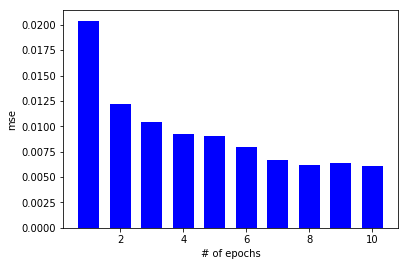

In [36]:
mse = [0.0204 , 0.0122 , 0.0104,  0.0092, 0.0090 ,  0.0080 , 0.0067, 0.0062, 0.0064 ,0.0061]
width = 1/1.5
plt.bar(range(1,11), mse, width, color="blue")
plt.ylabel('mse')
plt.xlabel('# of epochs')
plt.show()

In [11]:
decoded_imgs = autoencoder.predict(x_test_noisy)

In [12]:
rmse_pred_imgs = np.sqrt(np.mean((decoded_imgs - x_test)**2,axis = (1,2,3)))
sorted_idx = np.argsort(rmse_pred_imgs)

worst10 = sorted_idx[::-1][:10]
best10 = sorted_idx[:10]

In [46]:
#function to plot best 10 and worst 10 images
def plot_best10_worst10(b,w):
    print ("Best 10")
    print("Line 1 is original \nLine 2 is Noisy \nLine 3 is Predicted")
    n = 10
    plt.figure(figsize=(20, 4))
    for i,j in enumerate(b):
        #display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(x_test[j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(3, n, i+n+1)
        plt.imshow(x_test_noisy[j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i+(2*n)+1)
        plt.imshow(decoded_imgs[j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print ("Worst 10 \n")
    n = 10
    plt.figure(figsize=(20, 4))
    for i,j in enumerate(w):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(x_test[j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        #display noisy
        ax = plt.subplot(3, n, i+n+1)
        plt.imshow(x_test_noisy[j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i+2*n+1)
        plt.imshow(decoded_imgs[j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Best 10
Line 1 is original 
Line 2 is Noisy 
Line 3 is Predicted


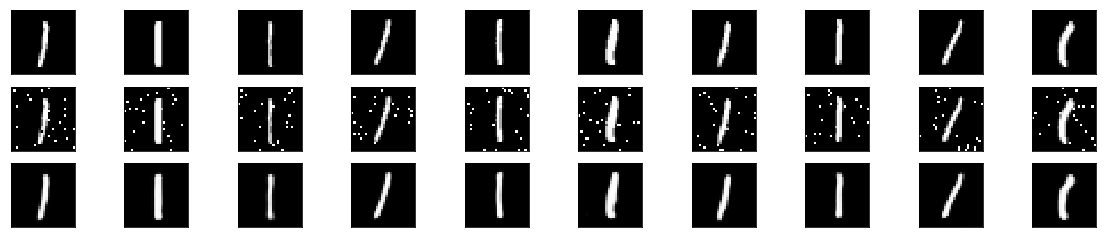

Worst 10 



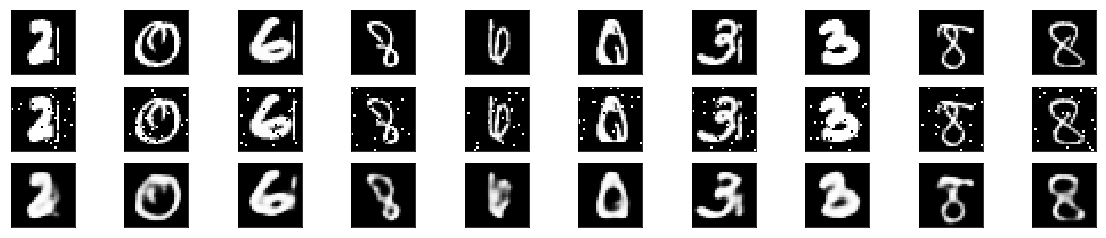

In [48]:
plot_best10_worst10(best10,worst10)

## Architecture 2

In [15]:
#Architechture 2

input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded2 = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded2)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder2 = Model(input_img, decoded2)
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ['mse'])

In [16]:
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 16)        0         
__________

In [17]:
from keras.callbacks import TensorBoard

autoencoder2.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 24000 samples, validate on 10000 samples
Epoch 1/10
24000/24000 [==============================] - 43s - loss: 0.2355 - mean_squared_error: 0.0569 - val_loss: 0.1331 - val_mean_squared_error: 0.0237
Epoch 2/10
24000/24000 [==============================] - 43s - loss: 0.1231 - mean_squared_error: 0.0203 - val_loss: 0.1107 - val_mean_squared_error: 0.0163
Epoch 3/10
24000/24000 [==============================] - 42s - loss: 0.1080 - mean_squared_error: 0.0152 - val_loss: 0.1018 - val_mean_squared_error: 0.0134
Epoch 4/10
24000/24000 [==============================] - 44s - loss: 0.1003 - mean_squared_error: 0.0126 - val_loss: 0.0975 - val_mean_squared_error: 0.0120
Epoch 5/10
24000/24000 [==============================] - 45s - loss: 0.0958 - mean_squared_error: 0.0112 - val_loss: 0.0923 - val_mean_squared_error: 0.0103
Epoch 6/10
24000/24000 [==============================] - 47s - loss: 0.0927 - mean_squared_error: 0.0102 - val_loss: 0.0922 - val_mean_squared_error: 0.0104
Ep

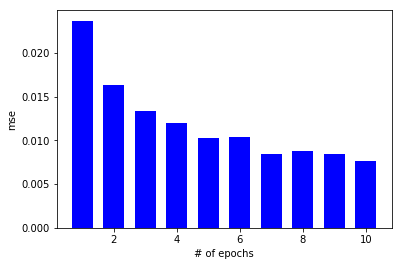

In [49]:
mse = [0.0237 , 0.0163 , 0.0134,  0.0120, 0.0103 ,  0.0104 , 0.0085, 0.0088, 0.0084 ,0.0076]
width = 1/1.5
plt.bar(range(1,11), mse, width, color="blue")
plt.ylabel('mse')
plt.xlabel('# of epochs')
plt.show()

In [18]:
decoded_imgs2 = autoencoder2.predict(x_test_noisy)

In [19]:
rmse_pred_imgs2 = np.sqrt(np.mean((decoded_imgs2 - x_test)**2,axis = (1,2,3)))
sorted_idx = np.argsort(rmse_pred_imgs2)

worst10 = sorted_idx[::-1][:10]
best10 = sorted_idx[:10]

Best 10
Line 1 is original 
Line 2 is Noisy 
Line 3 is Predicted


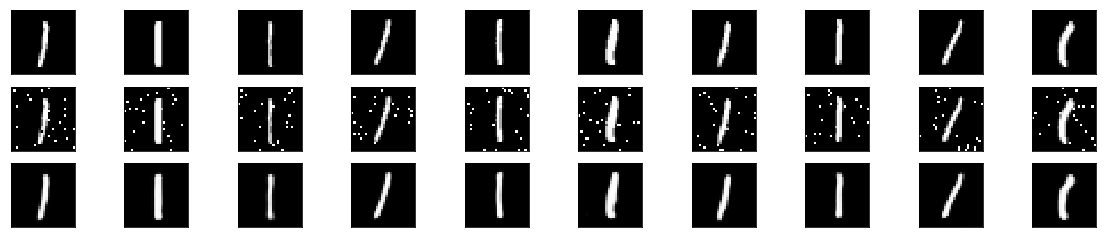

Worst 10 



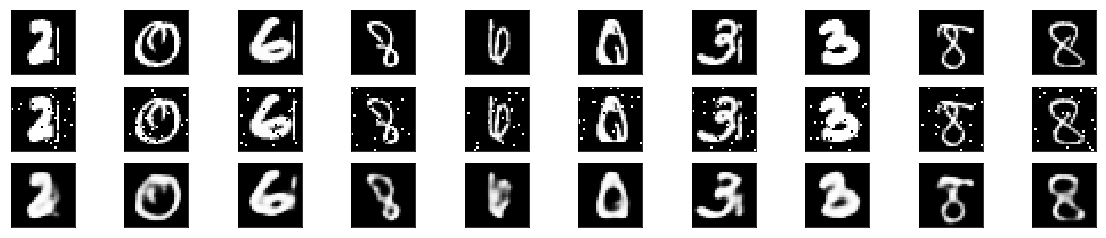

In [51]:
plot_best10_worst10(best10,worst10)

## Architecture 3

In [22]:
#Architechture 3

input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded3)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
decoded3 = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder3 = Model(input_img, decoded3)
autoencoder3.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ['mse'])

In [23]:
autoencoder3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 32)          9248      
__________

In [24]:
from keras.callbacks import TensorBoard

autoencoder3.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 24000 samples, validate on 10000 samples
Epoch 1/10
24000/24000 [==============================] - 197s - loss: 0.2019 - mean_squared_error: 0.0457 - val_loss: 0.1184 - val_mean_squared_error: 0.0189
Epoch 2/10
24000/24000 [==============================] - 194s - loss: 0.1073 - mean_squared_error: 0.0148 - val_loss: 0.0967 - val_mean_squared_error: 0.0117
Epoch 3/10
24000/24000 [==============================] - 268s - loss: 0.0953 - mean_squared_error: 0.0109 - val_loss: 0.0892 - val_mean_squared_error: 0.0091
Epoch 4/10
24000/24000 [==============================] - 191s - loss: 0.0893 - mean_squared_error: 0.0090 - val_loss: 0.0870 - val_mean_squared_error: 0.0081
Epoch 5/10
24000/24000 [==============================] - 198s - loss: 0.0860 - mean_squared_error: 0.0079 - val_loss: 0.0834 - val_mean_squared_error: 0.0070
Epoch 6/10
24000/24000 [==============================] - 281s - loss: 0.0840 - mean_squared_error: 0.0073 - val_loss: 0.0860 - val_mean_squared_error: 0.0

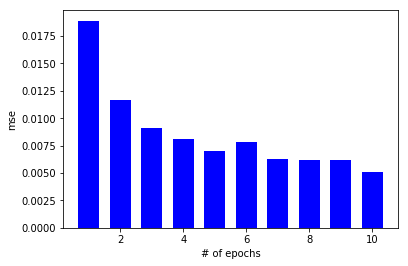

In [52]:
mse = [0.0189 , 0.0117 , 0.0091,  0.0081, 0.0070 ,  0.0078 , 0.0063, 0.0062, 0.0062 ,0.0051]
width = 1/1.5
plt.bar(range(1,11), mse, width, color="blue")
plt.ylabel('mse')
plt.xlabel('# of epochs')
plt.show()

In [25]:
decoded_imgs3 = autoencoder3.predict(x_test_noisy)

In [26]:
rmse_pred_imgs3 = np.sqrt(np.mean((decoded_imgs3 - x_test)**2,axis = (1,2,3)))
sorted_idx = np.argsort(rmse_pred_imgs3)

worst10 = sorted_idx[::-1][:10]
best10 = sorted_idx[:10]

Best 10
Line 1 is original 
Line 2 is Noisy 
Line 3 is Predicted


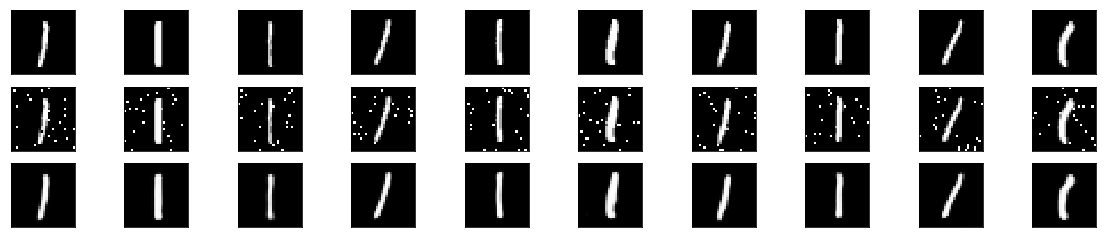

Worst 10 



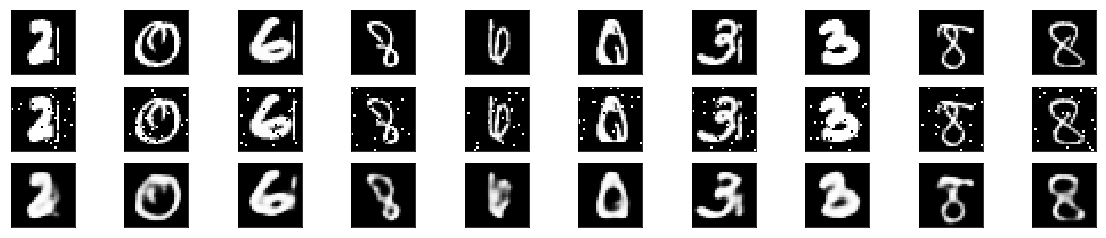

In [53]:
plot_best10_worst10(best10,worst10)

## Architechture 4

In [29]:
#Architechture 4

input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
encoded4 = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded4)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded4 = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder4 = Model(input_img, decoded4)
autoencoder4.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ['mse'])

In [30]:
autoencoder4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 32)          25632     
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [31]:
from keras.callbacks import TensorBoard

autoencoder4.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 24000 samples, validate on 10000 samples
Epoch 1/10
24000/24000 [==============================] - 196s - loss: 0.1967 - mean_squared_error: 0.0437 - val_loss: 0.1205 - val_mean_squared_error: 0.0191
Epoch 2/10
24000/24000 [==============================] - 195s - loss: 0.1106 - mean_squared_error: 0.0158 - val_loss: 0.1016 - val_mean_squared_error: 0.0128
Epoch 3/10
24000/24000 [==============================] - 198s - loss: 0.0980 - mean_squared_error: 0.0118 - val_loss: 0.0932 - val_mean_squared_error: 0.0101
Epoch 4/10
24000/24000 [==============================] - 193s - loss: 0.0917 - mean_squared_error: 0.0098 - val_loss: 0.0888 - val_mean_squared_error: 0.0087
Epoch 5/10
24000/24000 [==============================] - 187s - loss: 0.0879 - mean_squared_error: 0.0086 - val_loss: 0.0869 - val_mean_squared_error: 0.0081
Epoch 6/10
24000/24000 [==============================] - 194s - loss: 0.0855 - mean_squared_error: 0.0078 - val_loss: 0.0824 - val_mean_squared_error: 0.0

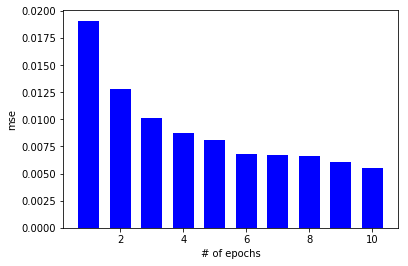

In [54]:
mse = [0.0191 , 0.0128 , 0.0101,  0.0087,  0.0081, 0.0068 ,  0.0067 , 0.0066, 0.0061 ,0.0055]
width = 1/1.5
plt.bar(range(1,11), mse, width, color="blue")
plt.ylabel('mse')
plt.xlabel('# of epochs')
plt.show()

In [32]:
decoded_imgs4 = autoencoder4.predict(x_test_noisy)

In [33]:
rmse_pred_imgs4 = np.sqrt(np.mean((decoded_imgs4 - x_test)**2,axis = (1,2,3)))
sorted_idx = np.argsort(rmse_pred_imgs4)

worst10 = sorted_idx[::-1][:10]
best10 = sorted_idx[:10]

Best 10
Line 1 is original 
Line 2 is Noisy 
Line 3 is Predicted


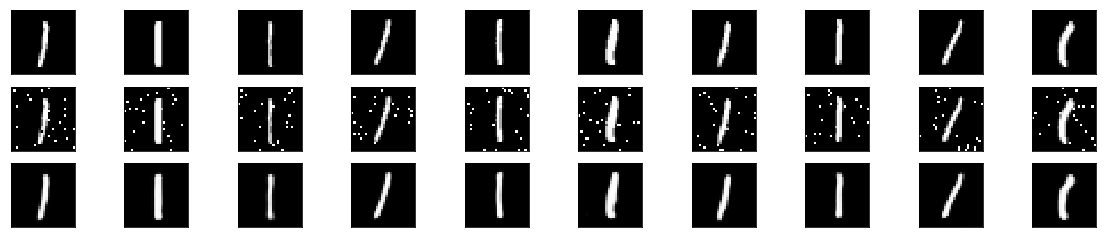

Worst 10 



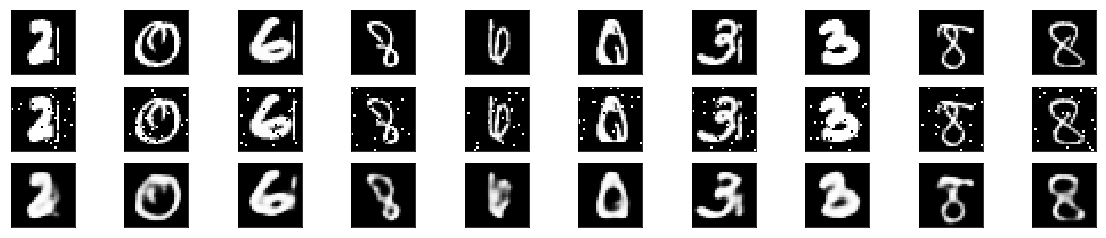

In [56]:
plot_best10_worst10(best10,worst10)

Least mse for test set is obtained for architecture 3. Hence this same architecture is utilized in Q3